# Strain-Stress Prediction:Task 1
Observe that there are four different measures to predict. The notebook we provide learns to make predictions for the equivalent (von Mises) stress (the “Seqv” column in the data). In the following steps, train models for at least one additional measure. How do you need to adapt the learning pipeline for that?

In [1]:
import pandas as pd
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from tqdm.auto import tqdm



In [2]:
preprocessed_folder = "preprocessed"

In [3]:

class FEData(Dataset):
    def __init__(self, predict_column: str, is_train: bool = True, folder: str = f"{preprocessed_folder}/input/01_baseline", split_at: int = 800) -> None:
        super().__init__()
        self.is_train = is_train
        self.predict_column = predict_column
        self.folder = folder
        self.split_at = split_at
        self._load_datasets()

    def __create_input_output_pair(self, file_path: str) -> Tuple[torch.Tensor, torch.Tensor]:
        df_input = pd.read_csv(file_path)[["FX", "FY"]]
        df_output = pd.read_csv(file_path.replace("input", "output"))[self.predict_column]
        inp = torch.tensor(df_input.to_numpy().reshape(-1)).float()
        out = torch.tensor(df_output.to_numpy().reshape(-1)).float()
        return inp, out

    def _load_datasets(self):
        self.data = []
        folder_output = self.folder.replace("input", "output")
        for r, d, f in os.walk(self.folder):
            for file_name in f:
                file_path = os.path.join(r, file_name)
                if self.is_train and int(file_path[-8:-4]) <= self.split_at:
                    inp, out = self.__create_input_output_pair(file_path)
                    self.data.append((inp, out))
                elif not self.is_train and int(file_path[-8:-4]) > self.split_at:
                    inp, out = self.__create_input_output_pair(file_path)
                    self.data.append((inp, out))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.data[index]
    
train_data = FEData("EPELeqv")
validation_data = FEData("EPELeqv", is_train=False)

* Create a data loader to get batches of data that we can iterate over.

In [4]:
train_loader = DataLoader(train_data, batch_size=800, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=200, shuffle=True)

* We next train a standard deep MLP model to predict the column "EPPLeqv".
* As optimizer, we are using adam.
* We use a scheduler to decrease the learning rate over time.

In [5]:
model = nn.Sequential(
    nn.Linear(84, 196),
    nn.ReLU(),
    nn.Linear(196, 196),
    nn.ReLU(),
    nn.Linear(196, 196),
    # nn.BatchNorm1d(196),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(196, 392),
    # nn.BatchNorm1d(392),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(392, 1014)
)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
model = model.train()

* It follows a "default" learning procedure in pytorch.
* We iterate over all our training data, calculate the loss and use backpropagation to calculate our gradients.
* An important detail here is that we scale the output of our model before calculating the loss function (see description further up).

In [6]:
model = model.train()
for epoch in range(200):# TODO: adapt number of epochs    
    with tqdm(train_loader) as pbar:
        for x, y in pbar:
            y_min = y.min(dim=1)[0].unsqueeze(1)
            y_max = y.max(dim=1)[0].unsqueeze(1)
            # print(y_min.shape, y_max.shape)
            y_pred = model(x)
            y_pred -= y_min
            y_pred /= (y_max - y_min)
            y -= y_min
            y /= (y_max - y_min)
            loss = criterion(y_pred, y) + criterion2(y_pred, y)
            pbar.set_description_str(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    scheduler.step()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

* Using the previous defined plot() funciton, we can illustrate the ground truth.
* Using the new plot_model() function, we can plot the output of our trained model.

In [7]:
def plot_model(model: nn.Module, file_path: str, column: str):
    df_out = pd.read_csv(file_path.replace("input", "output"))
    # get coordinates X and Y
    x_coords, y_coords = zip(*df_out[["X", "Y"]].to_numpy())

    model_input = torch.tensor(pd.read_csv(file_path)[["FX", "FY"]].to_numpy().reshape(1, -1)).float()
    with torch.no_grad():
        predicted = model.eval()(model_input)

    fig, ax = plt.subplots()
    ax.scatter(x_coords, y_coords, c=predicted, cmap='viridis', marker='o')
    cbar = plt.colorbar(ax.scatter([], [], c=[], cmap='viridis', vmin=predicted.min().item(), vmax=predicted.max().item()))
    ax.set_title("Predicted")
    return fig, ax

In [8]:
def plot_difference(model: nn.Module, file_path: str, column: str):
    df_out = pd.read_csv(file_path.replace("input", "output"))
    # get coordinates X and Y
    x_coords, y_coords = zip(*df_out[["X", "Y"]].to_numpy())
    gt = df_out[column].to_numpy().reshape(-1)
    model_input = torch.tensor(pd.read_csv(file_path)[["FX", "FY"]].to_numpy().reshape(1, -1)).float()
    with torch.no_grad():
        predicted = model.eval()(model_input).reshape(-1)
    difference = (predicted - gt).abs()
    fig, ax = plt.subplots()
    ax.scatter(x_coords, y_coords, c=difference, cmap='viridis', marker='o')
    cbar = plt.colorbar(ax.scatter([], [], c=[], cmap='viridis', vmin=difference.min().item(), vmax=difference.max().item()))
    ax.set_title("abs(ground truth - predicted)")
    return fig, ax

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'abs(ground truth - predicted)'}>)

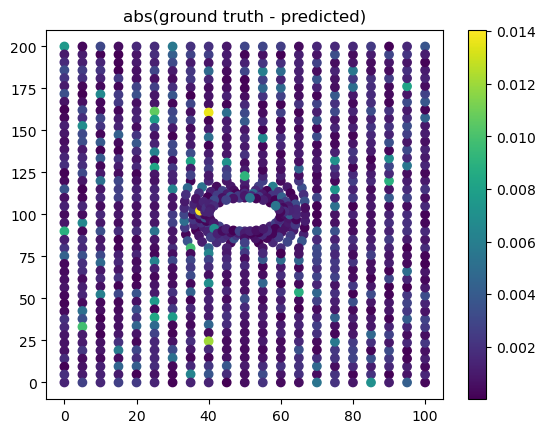

In [9]:
plot_difference(model, f"{preprocessed_folder}/input/01_baseline/fea_baseline_0001.csv", "EPELeqv")

* Still looks pretty good!
* But this is done on the training data. How would it look if we do this on the validation set?

In [10]:
plot(f"{preprocessed_folder}/output/01_baseline/fea_baseline_0801.csv", "EPELeqv")
plot_model(model, f"{preprocessed_folder}/input/01_baseline/fea_baseline_0801.csv", "EPELeqv")
plot_difference(model, f"{preprocessed_folder}/input/01_baseline/fea_baseline_0801.csv", "EPELeqv")

NameError: name 'plot' is not defined

* Ouch... Not quite as good as intended...
* The following code illustrates some more model performance evaluation.

Mean absolute error tensor(0.0041)
Median error tensor(0.0033)
Min error tensor(8.2655e-09)
Max error tensor(0.0183)


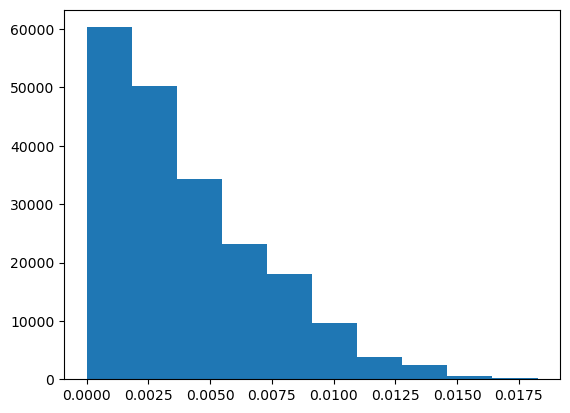

In [18]:
model = model.eval()
medians = []
means = []
model = model.eval() # important!!! because of dropout and normalization
with torch.no_grad():
    for x, y in val_loader: # Note: we only have one batch here, otherwise wehave to accumulate over all batches
        y_pred = model(x)
        diff = (y_pred - y[0]).abs()
        print("Mean absolute error", diff.mean())
        print("Median error", diff.median())
        print("Min error", diff.min())
        print("Max error", diff.max())
        plt.hist(diff.reshape(-1))

# Why is scaling model output important

* Take the following two ground truths as example

(<Figure size 640x480 with 2 Axes>, <Axes: title={'center': 'Ground Truth'}>)

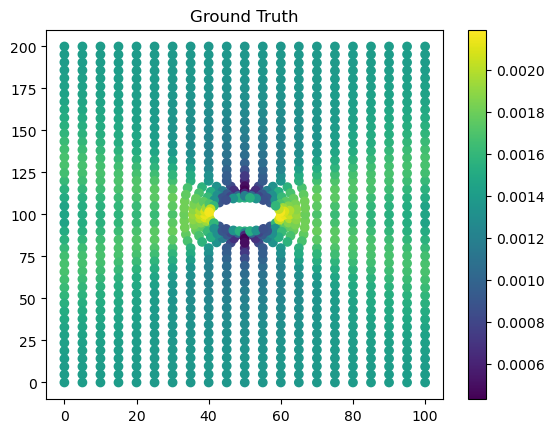

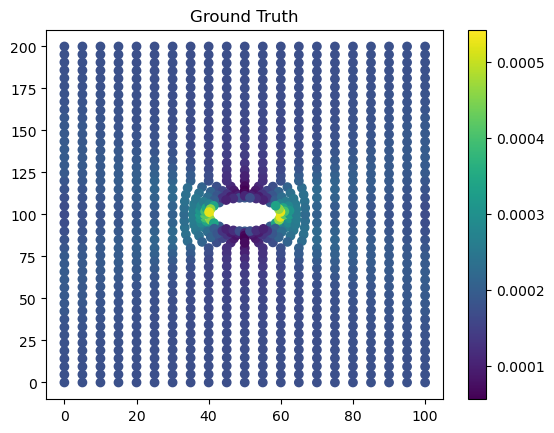

In [19]:
plot(f"{preprocessed_folder}/output/01_baseline/fea_baseline_0801.csv", "EPELeqv")
plot(f"{preprocessed_folder}/output/01_baseline/fea_baseline_0101.csv", "EPELeqv")

### Observations:
* While the max value in the first figure is around 400, in figure 2 it is around 100.
* A relative error of 10% would mean an absolute error of 40 in figure 1, but just 10 in figure 2.
* To counter that, we are calculating the loss by only using the relative error and not the absolute.

# TODO:

* Per sample, the values are not equally distributed: add weights for loss calculation or sample in different sizes.